# Social Computing Assignment 2

## Library

In [3]:
# install library
import matplotlib.pyplot as plt

In [4]:
# install library
import numpy as np

In [5]:
# install library
import pandas as pd

In [6]:
# dataset location
TRAIN_DIR = "absc-data/train.csv"
TEST_DIR = "absc-data/test.csv"

In [7]:
# output ans Categories used
OUTPUT_DIR = 'results'
CATEGORIES = ['Restaurant', 'Laptop']

## TASK - Part A


Part A: Analysis of Aspect Based Sentiment Classification Dataset

Objectives:

1) Find the 5 most frequently occurring aspects in the training set for each category (“restaurant”
and “laptop”) and visualize the data (category and frequency) using a bar graph (use matplotlib
library). You should have 2 bar graphs (one for each category).

2) Find the distribution of the number of aspects per sentence (the same sentence can contain
multiple aspects) in the entire training set and visualize the data using a bar graph. You can check
for sentences having 1, 2, 3 and more than 3 aspects. You should have a single bar graph

### Dataset

In [16]:
df = pd.read_csv(TRAIN_DIR)

# Lowercase all the aspect terms
df['Aspect Term'] = df['Aspect Term'].map(str.lower).map(str.strip)
# print(df['Aspect Term'])

### Part A1

1) Find the 5 most frequently occurring aspects in the training set for each category (“restaurant” and “laptop”) and visualize the data (category and frequency) using a bar graph (use matplotlib library). You should have 2 bar graphs (one for each category).

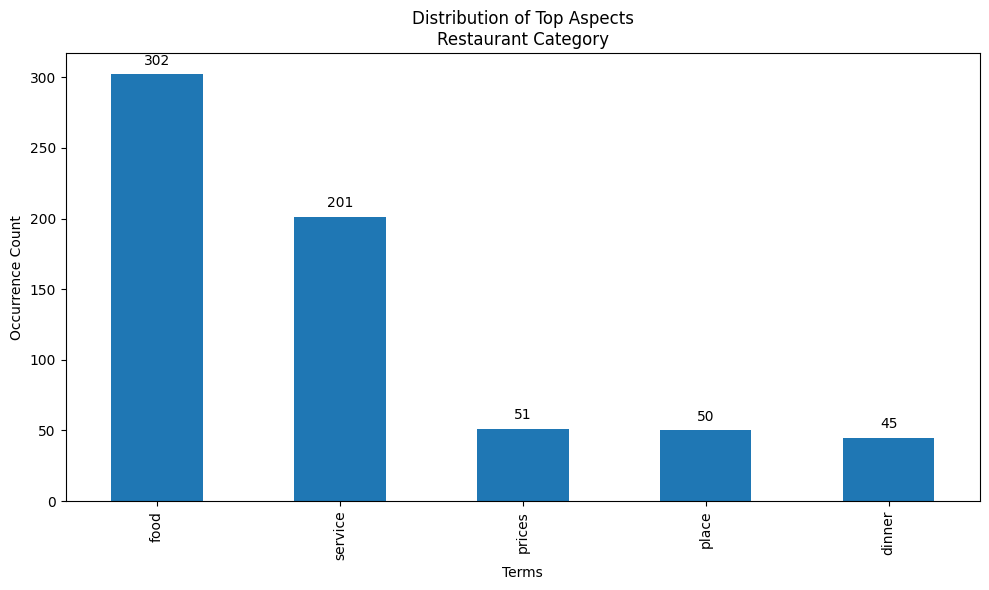

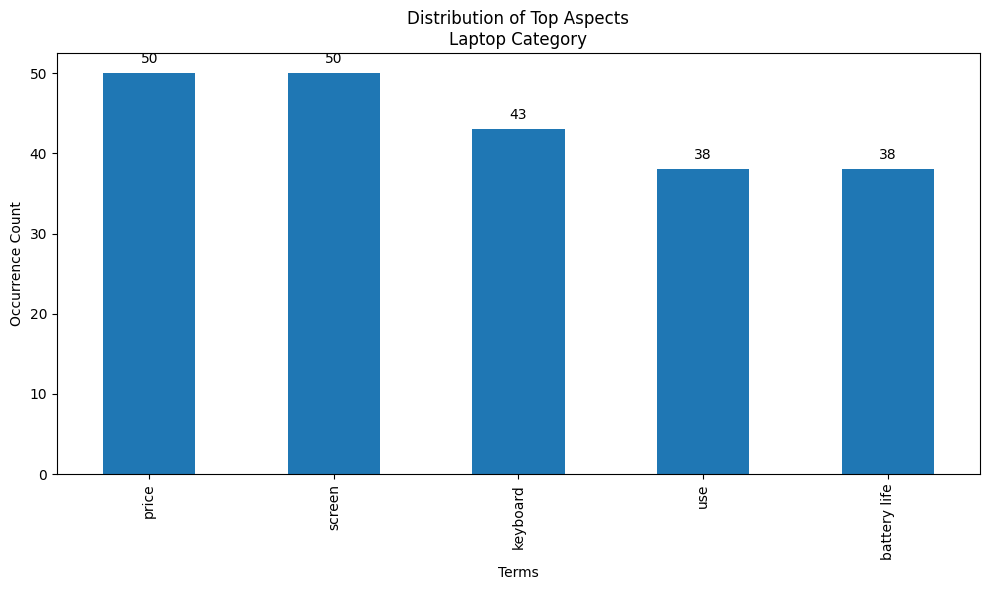

In [17]:
# Get top n frequent
def calculate_top_aspects(dataframe, category_name, n=5):
    category_slice = dataframe[dataframe['Category'] == category_name]
    return category_slice['Aspect Term'].value_counts().nlargest(n)

# create plot
def create_bar_visualization(data, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    data.plot(kind='bar', ax=ax)
    return ax

# edit labels
def add_value_labels(ax):
    for container in ax.containers:
        for bar in container:
            height = int(bar.get_height())
            ax.annotate(
                f'{height}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 5),
                textcoords='offset points',
                ha='center',
                va='bottom',
                fontsize=10,
                color='black'
            )

# generate plots
def generate_aspect_analysis(input_df, categories, output_path):
    for category in categories:
        aspect_data = calculate_top_aspects(input_df, category)
        plot = create_bar_visualization(
            aspect_data,
            f'Aspect Distribution in {category}'
        )
        add_value_labels(plot)
        plot.set_xlabel('Terms')
        plot.set_ylabel('Occurrence Count')
        plot.set_title(f'Distribution of Top Aspects\n{category} Category')

        plt.tight_layout()
        plt.savefig(f'{output_path}/aspect_analysis_{category.lower()}_dist.png')
        plt.show()

generate_aspect_analysis(df, CATEGORIES, OUTPUT_DIR)

### Part A2

2) Find the distribution of the number of aspects per sentence (the same sentence can contain multiple aspects) in the entire training set and visualize the data using a bar graph. You can check for sentences having 1, 2, 3 and more than 3 aspects. You should have a single bar graph

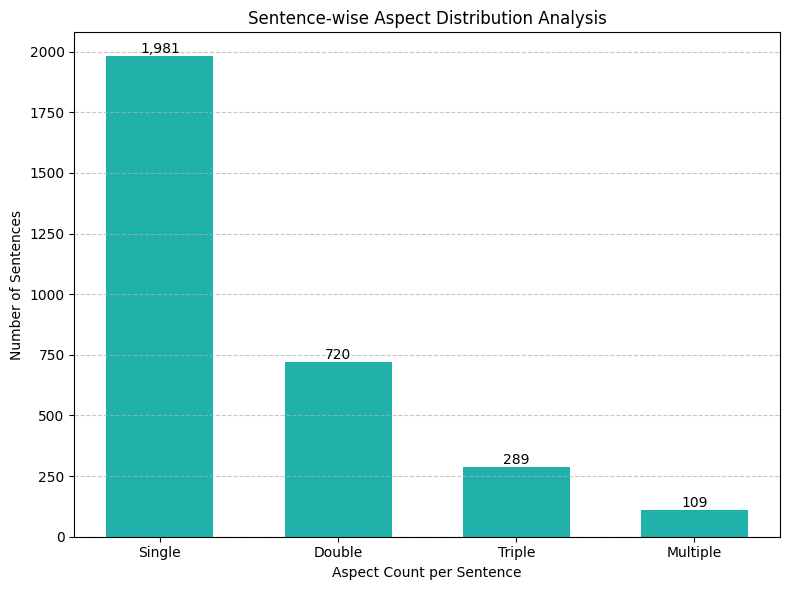

In [19]:
# counts - how many sentences have different numbers of aspects
def analyze_aspect_density(dataframe):
    density = dataframe.groupby('Sentence').agg({
        'Aspect Term': lambda x: len(set(x))
    }).squeeze()
    return {
        'Single': sum(density == 1),
        'Double': sum(density == 2),
        'Triple': sum(density == 3),
        'Multiple': sum(density > 3)
    }

# plot details
def create_distribution_plot(data_dict, color_scheme='lightseagreen'):
    # Setup figure with custom size
    fig, ax = plt.subplots(figsize=(8, 6))

    # Generate bar chart
    bar_container = ax.bar(
        list(data_dict.keys()),
        list(data_dict.values()),
        color=color_scheme,
        width=0.6
    )
    return ax, bar_container

# edit labels
def annotate_bars(ax, bars):
    for bar in bars:
        count = int(bar.get_height())
        ax.text(
            x=bar.get_x() + bar.get_width()/2,
            y=count,
            s=f'{count:,}',
            ha='center',
            va='bottom',
            fontsize=10,
            color='black'
        )

# plot
def visualize_aspect_distribution(df):
    aspect_counts = analyze_aspect_density(df)
    ax, bars = create_distribution_plot(aspect_counts)
    annotate_bars(ax, bars)
    ax.set_xlabel('Aspect Count per Sentence')
    ax.set_ylabel('Number of Sentences')
    ax.set_title('Sentence-wise Aspect Distribution Analysis')

    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

visualize_aspect_distribution(df)

## Part B

Models to be used:

1) Support Vector Machine (SVM) based sentiment classifier (Part B(1))

2) BERT based classifier (bert base uncased) (Part B(2))

Evaluation Metrics to be used for both classifier models:

1) Precision

2) Recall

3) F1 score

4) Accuracy

In [8]:
# install library
from sklearn.model_selection import train_test_split

In [9]:
# install library
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
# install library
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

In [11]:
# install library
from sklearn.model_selection import GridSearchCV

In [12]:
# install library
from sklearn.svm import SVC

In [13]:
# install library
import seaborn as sns

In [14]:
# install library
from sklearn.metrics import confusion_matrix

### Part B1: SVM

### Preprocessing

In [30]:
# Preprocessing
# Lowercase all the aspect terms
# Concatenate the aspect term and sentence

#train
train_df = pd.read_csv(TRAIN_DIR)
train_df['Aspect Term'] = train_df['Aspect Term'].map(str.lower).map(str.strip)
train_df['input_text'] = train_df.apply(lambda x: '{} [SEP] {}'.format(x['Aspect Term'], x['Sentence']), axis=1)

#test
test_df = pd.read_csv(TEST_DIR)
test_df['Aspect Term'] = test_df['Aspect Term'].map(str.lower).map(str.strip)
test_df['input_text'] = test_df.apply(lambda x: '{} [SEP] {}'.format(x['Aspect Term'], x['Sentence']), axis=1)


# Vectorize the tarin and test dataset
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['input_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['input_text'])

#### Model

In [32]:
#### Model
model = SVC()

# parameters
param_grid = {
    'kernel': ['rbf', 'linear', 'poly'],
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],
    'gamma': ['auto', 'scale', 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
}

# cross-validation - 5 folds
search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    refit=True
)

#### Train

In [33]:
# Train the model
search.fit(X_train_tfidf, train_df['Polarity'])

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'gamma': ['auto', 'scale', 0.0001, 0.001, 0.01, 0.1,
                                   1.0],
                         'kernel': ['rbf', 'linear', 'poly']},
             scoring='accuracy')

In [36]:
# Output performance metrics for each tested configuration
def Print_Model_Performamce_Configuration(search):
  print('Model Performance Across Parameter Sets:')
  accuracies = search.cv_results_['mean_test_score']
  deviations = search.cv_results_['std_test_score']
  param_sets = search.cv_results_['params']

  for acc, dev, params in zip(accuracies, deviations, param_sets):
      confidence_interval = dev * 2
      print(f"Configuration: {params}")
      print(f"Score: {acc:.3f} with confidence interval of ±{confidence_interval:.3f}\n")

Print_Model_Performamce_Configuration(search)

Model Performance Across Parameter Sets:
Configuration: {'C': 0.001, 'gamma': 'auto', 'kernel': 'rbf'}
Score: 0.521 with confidence interval of ±0.001

Configuration: {'C': 0.001, 'gamma': 'auto', 'kernel': 'linear'}
Score: 0.521 with confidence interval of ±0.001

Configuration: {'C': 0.001, 'gamma': 'auto', 'kernel': 'poly'}
Score: 0.521 with confidence interval of ±0.001

Configuration: {'C': 0.001, 'gamma': 'scale', 'kernel': 'rbf'}
Score: 0.521 with confidence interval of ±0.001

Configuration: {'C': 0.001, 'gamma': 'scale', 'kernel': 'linear'}
Score: 0.521 with confidence interval of ±0.001

Configuration: {'C': 0.001, 'gamma': 'scale', 'kernel': 'poly'}
Score: 0.521 with confidence interval of ±0.001

Configuration: {'C': 0.001, 'gamma': 0.0001, 'kernel': 'rbf'}
Score: 0.521 with confidence interval of ±0.001

Configuration: {'C': 0.001, 'gamma': 0.0001, 'kernel': 'linear'}
Score: 0.521 with confidence interval of ±0.001

Configuration: {'C': 0.001, 'gamma': 0.0001, 'kernel': 'p

In [37]:
# Get optimal configuration and model
optimal_parameters = search.best_params_
optimized_classifier = search.best_estimator_

print(f"Optimal parameters found: {optimal_parameters}")
print(f"Best performing model configuration: {optimized_classifier}")

Optimal parameters found: {'C': 1.0, 'gamma': 'auto', 'kernel': 'linear'}
Best performing model configuration: SVC(gamma='auto', kernel='linear')


#### evaluation on the Test set

In [39]:
# Generate and display model performance metrics
predictions = optimized_classifier.predict(X_test_tfidf)
print("Support Vector Machine Performance Analysis:")
y_test_ = test_df['Polarity']
print(classification_report(y_test_, predictions))

Support Vector Machine Performance Analysis:
              precision    recall  f1-score   support

    conflict       0.33      0.06      0.10        17
    negative       0.67      0.70      0.69       338
     neutral       0.62      0.38      0.47       228
    positive       0.77      0.88      0.82       628

    accuracy                           0.72      1211
   macro avg       0.60      0.50      0.52      1211
weighted avg       0.71      0.72      0.71      1211



#### Performance

In [41]:
# performance metrics
def display_performance_metrics(true_labels, predictions):
   p_score, r_score, f1_score, _ = precision_recall_fscore_support(
       true_labels,
       predictions,
       average='weighted'
   )
   acc = accuracy_score(true_labels, predictions)

   print("\nModel Performance Summary:")
   print("-" * 25)
   print(f"Precision Rate:  {p_score:>10.6f}")
   print(f"Recall Rate:    {r_score:>10.6f}")
   print(f"F1 Score:       {f1_score:>10.6f}")
   print(f"Accuracy:       {acc:>10.6f}")
   print("-" * 25)

y_test_ = test_df['Polarity']
display_performance_metrics(y_test_, predictions)


Model Performance Summary:
-------------------------
Precision Rate:    0.707082
Recall Rate:      0.721718
F1 Score:         0.705343
Accuracy:         0.721718
-------------------------


#### Confusion matrix

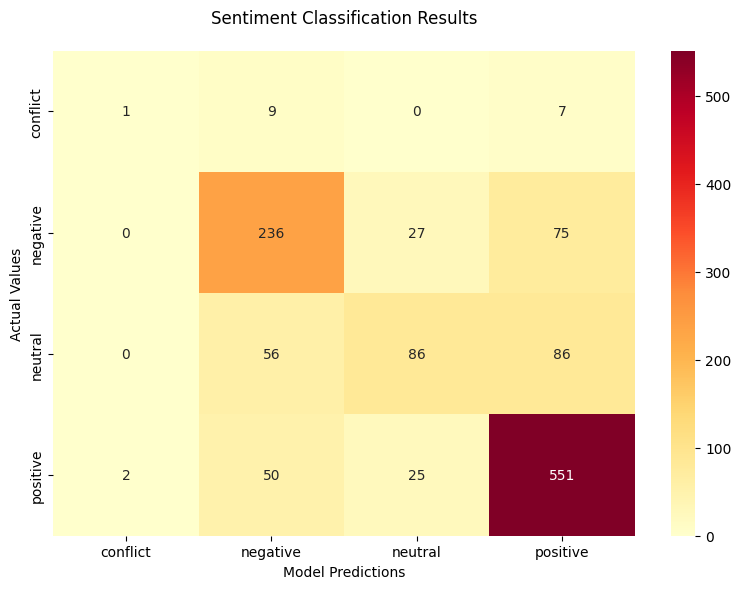

In [44]:
# plot confusion matrix
def visualize_confusion_matrix(y_true, y_pred):
    sentiment_categories = ['conflict', 'negative', 'neutral', 'positive']
    cm = confusion_matrix(
        y_true=y_true,
        y_pred=y_pred,
        labels=sentiment_categories
    )
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='YlOrRd',  # Different colormap
        xticklabels=sentiment_categories,
        yticklabels=sentiment_categories
    )

    plt.title('Sentiment Classification Results', pad=20)
    plt.xlabel('Model Predictions')
    plt.ylabel('Actual Values')

    plt.tight_layout()
    plt.show()

y_test_ = test_df['Polarity']
visualize_confusion_matrix(y_test_, predictions)

### Part B2: BERT

#### Library

In [13]:
import torch

In [14]:
!pip install ray

from ray import tune

2024-11-14 09:29:30,864	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-14 09:29:31,361	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [15]:
from transformers import TrainingArguments, EvalPrediction, Trainer

In [16]:
from torch.utils.data import Dataset

In [17]:
from sklearn.preprocessing import LabelEncoder

In [18]:
from transformers import BertForSequenceClassification, BertTokenizer

#### Preprocessing

In [19]:
####### Preprocessing

# Load data

# Lowercase all the aspect terms

# Concatenate the aspect term and sentence to construct the input text



#train

train_df = pd.read_csv(TRAIN_DIR)

train_df['Aspect Term'] = train_df['Aspect Term'].map(str.lower).map(str.strip)

train_df['input_text'] = train_df.apply(lambda x: '{} [SEP] {}'.format(x['Aspect Term'], x['Sentence']), axis=1)



#test

test_df = pd.read_csv(TEST_DIR)

test_df['Aspect Term'] = test_df['Aspect Term'].map(str.lower).map(str.strip)

test_df['input_text'] = test_df.apply(lambda x: '{} [SEP] {}'.format(x['Aspect Term'], x['Sentence']), axis=1)





# Encode labels



encoder = LabelEncoder()

train_polarity = train_df['Polarity']

test_polarity = test_df['Polarity']



# train

train_df['sentiment_encoded'] = encoder.fit_transform(train_polarity)



# test

test_df['sentiment_encoded'] = encoder.transform(test_polarity)


#### Model

In [ ]:
######### Model

# transformer tokenizer

nlp_processor = BertTokenizer.from_pretrained('bert-base-uncased')



# Process

train_sequences = nlp_processor(

    list(train_df['input_text']),

    padding=True,

    truncation=True,

)



# process

validation_sequences = nlp_processor(

    list(test_df['input_text']),

    padding=True,

    truncation=True,

)




tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# # Data structure for holding tokenized text and sentiment pairs

# pytorch

class AspectBasedSentimentDataset(Dataset):

    def __init__(self, encodings, labels):

        self.labels = labels

        self.encodings = encodings



    def __getitem__(self, idx):

        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

        item['labels'] = torch.tensor(self.labels[idx])

        return item



    def __len__(self):

        return len(self.labels)





# create datatset (tarin and test/validation) by mapping the dataset to the SentimentDataset class

def create_sentiment_datasets(train_sequences, validation_sequences,

                            train_df, test_df, label_col='sentiment_encoded'):

    train_data = AspectBasedSentimentDataset(

        train_sequences,

        train_df[label_col].tolist()

    )



    val_data = AspectBasedSentimentDataset(

        validation_sequences,

        test_df[label_col].tolist()

    )



    return train_data, val_data



# Model initialization

def initialize_bert_classifier(num_sentiment_classes: int):

    """Initialize BERT model for sentiment classification"""

    return BertForSequenceClassification.from_pretrained(

        'bert-base-uncased',

        num_labels=num_sentiment_classes,

    )



# model instance

def get_model():

    return initialize_bert_classifier(num_sentiment_classes=len(encoder.classes_))  



train_data, val_data = create_sentiment_datasets(

    train_sequences,

    validation_sequences,

    train_df,

    test_df

)






################ Model Training

#### Model training

In [ ]:
# metric mapping
def get_metrics(pred: EvalPrediction) -> dict:

    y_true = pred.label_ids

    y_pred = pred.predictions.argmax(-1)



    # Get all metrics at once

    p, r, f, _ = precision_recall_fscore_support(

        y_true,

        y_pred,

        average='weighted'

    )



    return {

        'accuracy': accuracy_score(y_true, y_pred),

        'precision': p,

        'recall': r,

        'f1': f

    }


# configuration
train_config = TrainingArguments(

    output_dir = "./model_outputs",

    evaluation_strategy = "epoch",

    save_strategy = "no",

    logging_dir = "./training_logs",

)



# Setup model training

trainer = Trainer(

    model_init=get_model,

    args=train_config,

    compute_metrics=get_metrics,

    train_dataset=train_data,

    eval_dataset=val_data

)




/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# from google.colab import userdata

# mysecret = userdata.get('wandb_apikey')
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_apikey")



In [24]:
import wandb


In [ ]:


def initialize_wandb():

    try:

        wandb.login(key=secret_value_0)

    except Exception as e:

        print(f"Wandb initialization failed: {e}")



initialize_wandb()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [26]:
!pip install optuna

import optuna

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:

# hyperparameter space

def get_hyperparam_space(trial: optuna.Trial) -> dict:

   return {

       'num_train_epochs': trial.suggest_categorical(

           name='num_train_epochs',

           choices=[2, 3, 4]

       ),

       'learning_rate': trial.suggest_float(

           name='learning_rate',

           low=1e-5,

           high=5e-5

       ),

       'per_device_train_batch_size': trial.suggest_categorical(

           name='per_device_train_batch_size',

           choices=[8, 16, 32]

       )


   }



# Run optimization

optimal_params = trainer.hyperparameter_search(

   hp_space=get_hyperparam_space,

   direction="maximize",

   backend="optuna"

)

[I 2024-11-14 09:30:11,751] A new study created in memory with name: no-name-cd271150-9b9a-4c69-a15c-a92d4c979675
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Currently logged in as: yogmanamitkr1 (yogmanamitkr1-iit-kharagpur). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241114_093013-m2zpbzbc
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run hardy-sponge-2
wandb: ⭐️ View project at https://wandb.ai/yogmanamitkr1-iit-kharagpur/huggingface
wandb: 🚀 View run at https://wandb.ai/yogmanamitkr1-iit-kharagpur/huggingface/runs/m2zpbzbc
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: Fu

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.587667,0.797521,0.774777,0.797521,0.772576
2,No log,0.460708,0.844215,0.820397,0.844215,0.827739


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.668499,0.770661,0.750259,0.770661,0.735870
2,No log,0.601469,0.792562,0.765118,0.792562,0.771689


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.516452,0.824174,0.804013,0.824174,0.803630
2,No log,0.371470,0.872107,0.849837,0.872107,0.857798


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.664866,0.773140,0.746406,0.773140,0.744233
2,No log,0.577513,0.802479,0.775932,0.802479,0.782962


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.589767,0.792149,0.770055,0.792149,0.765396
2,No log,0.382996,0.875620,0.852720,0.875620,0.863064
3,No log,0.259700,0.919421,0.915547,0.919421,0.912686
4,No log,0.217224,0.936157,0.933882,0.936157,0.932785


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.709588,0.747521,0.729905,0.747521,0.703650


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-11-14 09:46:09,691] Trial 5 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           eval/accuracy ▁
wandb:                 eval/f1 ▁
wandb:               eval/loss ▁
wandb:          eval/precision ▁
wandb:             eval/recall ▁
wandb:            eval/runtime ▁
wandb: eval/samples_per_second ▁
wand

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.614564,0.790702,0.768740,0.790702,0.762798


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-11-14 09:47:31,542] Trial 6 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           eval/accuracy ▁
wandb:                 eval/f1 ▁
wandb:               eval/loss ▁
wandb:          eval/precision ▁
wandb:             eval/recall ▁
wandb:            eval/runtime ▁
wandb: eval/samples_per_second ▁
wand

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.522624,0.815909,0.794517,0.815909,0.799231
2,0.690300,0.314261,0.896488,0.898178,0.896488,0.886950
3,0.690300,0.176961,0.946281,0.944868,0.946281,0.945343
4,0.347300,0.129023,0.959917,0.959524,0.959917,0.959680


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.aut

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.509068,0.831198,0.810003,0.831198,0.817238
2,No log,0.277085,0.908058,0.908023,0.908058,0.902590
3,No log,0.150139,0.958058,0.957481,0.958058,0.957449
4,0.502600,0.101513,0.970248,0.970239,0.970248,0.970204


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.aut

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.516526,0.819008,0.799307,0.819008,0.798499
2,0.678200,0.358344,0.871074,0.866243,0.871074,0.858789


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
[I 2024-11-14 10:02:43,867] Trial 9 pruned. 
Some weights of BertForSequenceClassification were not initialized fr

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.537755,0.817769,0.794449,0.817769,0.799481


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-11-14 10:04:05,759] Trial 10 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           eval/accuracy ▁
wandb:                 eval/f1 ▁
wandb:               eval/loss ▁
wandb:          eval/precision ▁
wandb:             eval/recall ▁
wandb:            eval/runtime ▁
wandb: eval/samples_per_second ▁
wan

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.534595,0.812603,0.794661,0.812603,0.794163


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-11-14 10:05:47,815] Trial 11 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           eval/accuracy ▁
wandb:                 eval/f1 ▁
wandb:               eval/loss ▁
wandb:          eval/precision ▁
wandb:             eval/recall ▁
wandb:            eval/runtime ▁
wandb: eval/samples_per_second ▁
wan

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.514656,0.817769,0.796073,0.817769,0.799552
2,0.678300,0.283440,0.910950,0.910039,0.910950,0.908550
3,0.678300,0.136632,0.961364,0.961878,0.961364,0.961530
4,0.314000,0.092948,0.971694,0.971821,0.971694,0.971720


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.aut

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.501383,0.826446,0.803550,0.826446,0.811596
2,0.676500,0.269805,0.916322,0.916963,0.916322,0.915721
3,0.676500,0.129181,0.959917,0.960314,0.959917,0.960066
4,0.302100,0.080386,0.975826,0.976471,0.975826,0.976049


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.aut

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.516698,0.815909,0.797368,0.815909,0.798957


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-11-14 10:20:39,892] Trial 14 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           eval/accuracy ▁
wandb:                 eval/f1 ▁
wandb:               eval/loss ▁
wandb:          eval/precision ▁
wandb:             eval/recall ▁
wandb:            eval/runtime ▁
wandb: eval/samples_per_second ▁
wan

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.509832,0.821281,0.802545,0.821281,0.806749
2,0.678200,0.270103,0.912810,0.914082,0.912810,0.911383
3,0.678200,0.124117,0.961777,0.962972,0.961777,0.962256
4,0.301900,0.078799,0.977479,0.978036,0.977479,0.977689


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.aut

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.493664,0.825207,0.800176,0.825207,0.808556
2,0.680700,0.276838,0.909298,0.912012,0.909298,0.909873


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
[I 2024-11-14 10:30:34,466] Trial 16 pruned. 
Some weights of BertForSequenceClassification were not initialized f

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.574902,0.792355,0.776685,0.792355,0.776755


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-11-14 10:32:15,447] Trial 17 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           eval/accuracy ▁
wandb:                 eval/f1 ▁
wandb:               eval/loss ▁
wandb:          eval/precision ▁
wandb:             eval/recall ▁
wandb:            eval/runtime ▁
wandb: eval/samples_per_second ▁
wan

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.501786,0.820455,0.797277,0.820455,0.803945
2,0.680700,0.277758,0.905372,0.902286,0.905372,0.899094


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
[I 2024-11-14 10:35:34,481] Trial 18 pruned. 
Some weights of BertForSequenceClassification were not initialized f

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.509952,0.824380,0.802086,0.824380,0.810268
2,0.674800,0.290177,0.909091,0.916043,0.909091,0.908711


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
[I 2024-11-14 10:38:53,964] Trial 19 pruned. 


#### parameters - choosing optimal one

In [ ]:
# print optimal parameters

optimized_params = dict(optimal_params.hyperparameters.items())

print("Best hyperparameters found:", optimized_params)



# use optimal parameters

def update_trainer_config(trainer, param_dict):

   for param_name, param_value in param_dict.items():

       setattr(trainer.args, param_name, param_value)



update_trainer_config(trainer, optimized_params)

Best hyperparameters found: {'num_train_epochs': 4, 'learning_rate': 4.9195827336361806e-05, 'per_device_train_batch_size': 8}


In [29]:
# Train

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.509832,0.821281,0.802545,0.821281,0.806749
2,0.678200,0.270103,0.912810,0.914082,0.912810,0.911383
3,0.678200,0.124117,0.961777,0.962972,0.961777,0.962256
4,0.301900,0.078799,0.977479,0.978036,0.977479,0.977689


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.aut

TrainOutput(global_step=1212, training_loss=0.4324274661123949, metrics={'train_runtime': 391.9894, 'train_samples_per_second': 49.389, 'train_steps_per_second': 3.092, 'total_flos': 1016753375604096.0, 'train_loss': 0.4324274661123949, 'epoch': 4.0})

#### evaluation on the Test set

In [ ]:
# final evaluation

results = trainer.evaluate()





# performance metrics

def display_metrics(metrics_dict):

   print("\nModel Evaluation Results:")

   print("-" * 25)

   for metric, value in metrics_dict.items():

       if metric.startswith('eval_'):

           metric_name = metric.replace('eval_', '').upper()

           print(f"{metric_name}: {value:.4f}")



display_metrics(results)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '



Model Evaluation Results:
-------------------------
LOSS: 0.0788
ACCURACY: 0.9775
PRECISION: 0.9780
RECALL: 0.9775
F1: 0.9777
RUNTIME: 24.3849
SAMPLES_PER_SECOND: 198.4830
STEPS_PER_SECOND: 12.4260


#### Confusion Matrix

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


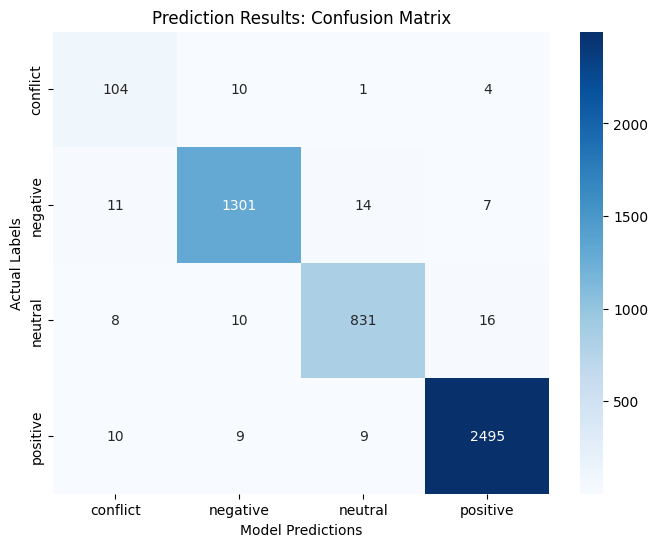


Detailed Performance Analysis:
              precision    recall  f1-score   support

    conflict       0.78      0.87      0.83       119
    negative       0.98      0.98      0.98      1333
     neutral       0.97      0.96      0.97       865
    positive       0.99      0.99      0.99      2523

    accuracy                           0.98      4840
   macro avg       0.93      0.95      0.94      4840
weighted avg       0.98      0.98      0.98      4840



In [ ]:
import numpy as np

from sklearn.metrics import confusion_matrix

import seaborn as sns





def get_model_predictions(trainer, test_data):

   """Get model predictions and true labels"""

   model_output = trainer.predict(test_data)

   return {

       'predicted': np.argmax(model_output.predictions, axis=1),

       'actual': model_output.label_ids

   }



def plot_confusion_matrix(y_true, y_pred, class_labels):

   """Visualize confusion matrix as heatmap"""

   matrix = confusion_matrix(y_true, y_pred)



   fig = plt.figure(figsize=(8, 6))

   sns.heatmap(

       matrix,

       annot=True,

       fmt='d',

       cmap='Blues',

       xticklabels=class_labels,

       yticklabels=class_labels

   )



   plt.title('Prediction Results: Confusion Matrix')

   plt.xlabel('Model Predictions')

   plt.ylabel('Actual Labels')

   plt.show()



def analyze_model_performance(trainer, test_data, label_names):

   """Generate and display model evaluation metrics"""

   # Get predictions

   labels = get_model_predictions(trainer, test_data)



   # Generate confusion matrix plot

   plot_confusion_matrix(

       labels['actual'],

       labels['predicted'],

       label_names

   )



   # Show detailed metrics

   print("\nDetailed Performance Analysis:")

   print(classification_report(

       labels['actual'],

       labels['predicted'],

       target_names=label_names

   ))



# Run analysis

analyze_model_performance(

   trainer,

   val_data,

   encoder.classes_

)